# INBOX: (I)nspect the (N)on-(B)acktracking (o)r (X)-centrality of graphs

This notebook contains example usage of all functions found in the `inbox` package. It is meant to be additional documentation on top of the docstrings provided in the source code. This document is not meant to contain a deep explanation of the underlying concepts. For that, please see the paper.

In [1]:
import inbox
import numpy as np
import networkx as nx
import scipy.sparse as sparse
import matplotlib.pylab as plt

For all our examples we will use the Karate Club network,

In [2]:
graph = nx.karate_club_graph()

`inbox` provides functions that compute three different related topics: matrices, centralities, and targeted immunization, presented in the following sections. If you plan on using `inbox` for heavy duty computing (large and/or many networks), please also read the final section "Implementation Notes".

-----

# Matrices

### Non-Backtracking matrix

The fundamental matrix used is the Non-Backtracking matrix (or NB-matrix). The NB-matrix of a graph is computed using `nb_matrix`. This matrix has a number of rows and columns equal to twice the number of edges in the graph.

In [3]:
nbm = inbox.nb_matrix(graph)
2*graph.size(), nbm.shape

(156, (156, 156))

A different version of the NB-matrix is the auxiliary NB-matrix. This is a smaller matrix, with size equal to twice the number of nodes of the graph.

In [4]:
aux = inbox.nb_matrix(graph, aux=True)
2*graph.order(), aux.shape

(68, (68, 68))

The utility of the auxiliary version is that all its eigenvalues are also eigenvalue of the NB-matrix.

In [5]:
nbm_vals = sparse.linalg.eigs(nbm, k=10, return_eigenvectors=False)
aux_vals = sparse.linalg.eigs(aux, k=10, return_eigenvectors=False)
nbm_vals.sort()
aux_vals.sort()
np.allclose(nbm_vals, aux_vals)

True

The rows and columns of the NB-matrix are indexed by directed edges of the graph, even if the graph is undirected. The rows and columns of the NB-matrix are by default sorted as follows. The first $m$ rows correspond to the edges in the orientation found in the NetworkX graph. The last $m$ edges correspond to the opposite orientations, in the same order. That is to say, if the first edge returned by `graph.edges()` is `(u ,v)`, then the first row corresponds to the directed edge `u -> v`, while the $m^{th}$ row corresponds to the directed edge `v -> u`.

This row order creates a rather appealing visual structure in the matrix.

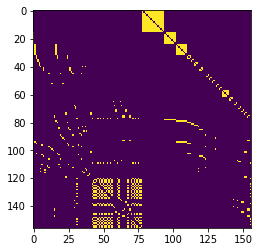

In [6]:
plt.imshow(nbm.A);

The auxiliary NB-matrix is a $2 \times 2$ block matrix whose bottom right block is the adjacency matrix of the graph.

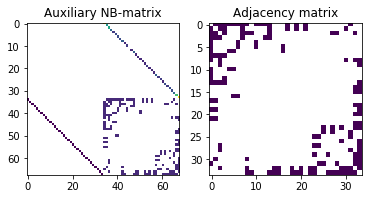

In [7]:
_, axes = plt.subplots(1, 2);
aux_plot = aux.A
aux_plot[aux_plot == 0] = 'nan'
axes[0].imshow(aux_plot);
axes[0].set_title('Auxiliary NB-matrix')

adj_plot = nx.adjacency_matrix(graph).A.astype('d')
adj_plot[adj_plot == 0] = 'nan'
axes[1].imshow(adj_plot);
axes[1].set_title('Adjacency matrix');

As can be seen, there is a very rich structure in the rows and columns of these matrices.

### The permutation matrix

The NB-matrix is not symmetric and therefore its spectral analysis can become cumbersome. However, it contains non-standard forms of symmetry. Concretely, a permutation of its rows and columns will make it symmetric.

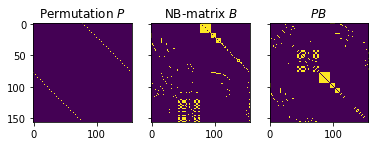

In [8]:
perm = inbox.perm_matrix(nbm.shape[0] // 2)
_, axes = plt.subplots(1, 3, sharey=True);
axes[0].imshow(perm.A);
axes[0].set_title(r'Permutation $P$');
axes[1].imshow(nbm.A);
axes[1].set_title(r'NB-matrix $B$');
axes[2].imshow(perm.dot(nbm).A);
axes[2].set_title(r'$PB$');

Note that the order of rows and columns is extremeley important in all the above computations, and choosing a different basis will invalidate these properties.

### Half incidence matrices

The half incidence matrices are two rectangular matrices that are used when computing the NB-matrix and other associated computations. They store information about the incidence of directed edges to their (source and target) endpoints. By default, the columns are sorted in the same way as the NB-matrix. Once again, the order is extremely important.

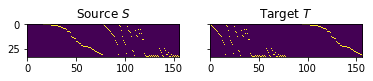

In [9]:
source, target = inbox.half_incidence(graph)
_, axes = plt.subplots(1, 2, sharey=True);
axes[0].imshow(source.A);
axes[0].set_title(r'Source $S$');
axes[1].imshow(target.A);
axes[1].set_title(r'Target $T$');

Note that the product of the source and target matrices is *almost* the NB-matrix, but not quite.

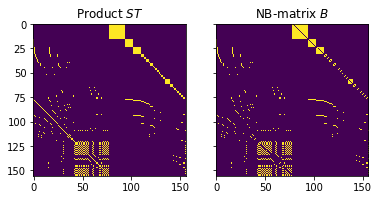

In [10]:
_, axes = plt.subplots(1, 2, sharey=True)
axes[0].imshow(source.T.dot(target).A);
axes[0].set_title(r'Product $ST$')
axes[1].imshow(nbm.A);
axes[1].set_title(r'NB-matrix $B$');

In fact, the product of soruce and target minus the permutation matrix equals the NB-matrix

In [11]:
np.allclose((source.T.dot(target) - perm).A, nbm.A)

True

### X matrix

The `X` matrix is used when defining the `X`-centrality framework, in particular the `X`-Non-Backtracking centrality and `X`-degree centrality. `inbox` can compute the `X` matrix in both cases of node removal or node addition. Further, `inbox` can also compute the `X`-centrality measures, as discussed in the Section.

#### Node removal

Removing a node from the graph is equivalent to removing some rows from the NB-matrix. By re-arranging the rows and columns, we can get a nice block formation for the NB-matrix. However, this must be made carefully since the row order is so important.

To see what these blocks are when removing a node, we can do the following,

In [12]:
node_to_remove = 2
B, D, E, F = inbox.x_matrix(graph, remove_node=node_to_remove, return_all=True)

Now, the matrix 

    [B', D]
    [E , F]

is the same as the NB-matrix, but with reordered rows and columns. `E` is indexed in the rows by those that would be removed when removing the node, while the same is true for the columns of `D`. `F` is completely removed when removing the node.

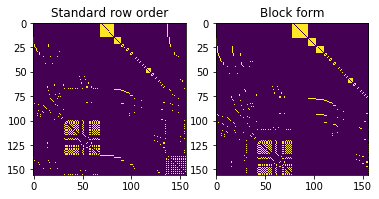

In [13]:
_, axes = plt.subplots(1, 2)
axes[0].imshow(sparse.bmat([[B, D],
                            [E, F]]).A);
axes[0].set_title(r'Standard row order')
axes[1].imshow(nbm.A);
axes[1].set_title(r'Block form');

Therefore, the NB-matrix of the graph after removing the node is exactly equal to `B'`, the top-left block, but we did not need to recompute the new order of rows and columns.

Finally, the `X` matrix is defined as the product of `D`, `F`, `E`. In fact, it can be computed directly by using `return_all=False`,

In [14]:
X = D.dot(F).dot(E)

# Use return_all=False to get only the X matrix
X2 = inbox.x_matrix(graph, remove_node=node_to_remove, return_all=False)

np.allclose(X2.A, X.A)

True

#### Node addition

When adding a new node to the graph, the NB-matrix can be put in a similar block form as before. In this case, `F` is a whole new block of the new matrix, while `E` is indexed in the rows by the newly added directed edges, while the same is true for the columns of `D`. In this case, the NB-matrix of the graph after node addition is

    [B D]
    [E F],
    
where `B` is the NB-matrix of the original graph before node addition. `x_matrix` can also compute the blocks in this case, by specifying the neighbors of the node to be added, rather than a node to be removed. This is done via `add_neighbors`.

In [15]:
B, D, E, F = inbox.x_matrix(graph, add_neighbors=[0, 13, 30], return_all=True)
X = D.dot(F).dot(E)
X2 = inbox.x_matrix(graph, add_neighbors=[0, 13, 30], return_all=False)
np.allclose(X.A, X2.A)

True

Note that `x_matrix` function never adds or removes a node from the graph, but only returns the `X` matrix, or the blocks `B`, `D`, `E`, `F` in an appropriate row order.

-----

# Centralities

`inbox` contains functionality to compute several centrality measures. Notably, it can compute X-degree and X-NB centrality. To compute these, it is always better to use the following functions, rather than computing the `X` matrix and directly operating with it.

### X-NB centrality

The first is X-NB centrality, which uses the `X` matrix from above. It is an aggregation of the NB-centralities of a node's neighbors. For details, see the paper.

In [16]:
xnb_cent = inbox.x_nb_centrality(graph)

### X-degree centrality

The second is X-degree centrality, which is an aggregation of a node's neighbors' degrees.

In [17]:
xdeg_cent = inbox.x_degree(graph)

### General X-centrality

One can also compute arbitrary centrality measures using the `X` matrix. If `vector` contains a centrality value for each directed edge (with elements sorted in the same row order as the NB-matrix), then one can use the following to transform these values into node centralities,

In [18]:
directed_edge_centralities = np.random.random(size=2*graph.size())
x_cent = inbox.x_centrality(graph, directed_edge_centralities)

### NB centrality

NB-centrality was first proposed by [[1](#ref-1)]  as an alternative to the standard eigenvector centrality that is more robust to localization.

In [19]:
nb_cent = inbox.nb_centrality(graph)

NB-centrality is by default normalized in an appropriate way (see paper for details). An unnormalized version is also available. The unnormalized version is slightly more efficient to compute (in the order of $O(n)$).

In [20]:
nb_cent_unnormalized = inbox.nb_centrality(graph, normalized=False)

Note: in the course of computing `nb_centrality`, the leading eigenvalue of the NB-matrix of the graph is computed, and can also be returned by using the option `return_eigenvalue=True`.

### Collective Influence

Finally, collective influence was proposed by [[3](#ref-3)] as another centrality measure based on the NB-matrix. `inbox` considers only the immediate neighbors of a node to compute its collective influence, but generalizations are possible.

In [21]:
ci_cent = inbox.collective_influence(graph)

### Visualization

When putting together all centrality measures we get the following picture of the network.

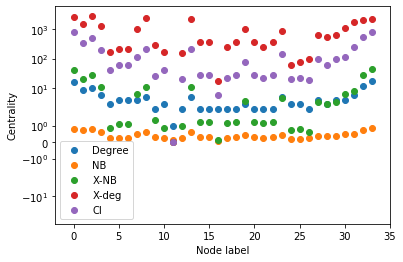

In [22]:
# As a baseline, also show degree
deg_cent = dict(graph.degree())

scatter = lambda c, l: plt.scatter([n for n in graph], [c[n] for n in graph], label=l)
scatter(deg_cent, 'Degree');
scatter(nb_cent, 'NB');
scatter(xnb_cent, 'X-NB');
scatter(xdeg_cent, 'X-deg');
scatter(ci_cent, 'CI');
plt.yscale('symlog');
plt.xlabel('Node label');
plt.ylabel('Centrality');
plt.legend();

As can be seen, they are all highly correlated to each other. CI and X-deg can be computed most efficiently. X-NB and X-deg are the best choices for immunization purposes.

-----

# Immunization

Targeted immunization works by (i) computing a score of each node, (ii) removing the node with the highest score, and (iii) iterating until the target number of nodes has been removed. Importantly, the score has to be recomputed at each step. `inbox` provides functionality to perform targeted immunization using all of the above centrality measures to compute the score. Among these, X-degree and CI are the fastest computationally, though X-NB was observed to be the most effective.

In [23]:
removed_nodes, new_graph = inbox.immunize(graph, 5, strategy='xdeg')

`inbox.immunize` supports the following strategies for computing the score: `deg` (degree), `core` ($k$-core index, or coreness), `nb` (NB centrality), `xnb` (X-NB centrality), `xdeg` (X-degree centrality), `ci` (Collective Influence), `ns` (NetShield). NetShield [[4](#ref-4)] is an efficient algorithm based on the adjacency matrix, not on the NB-matrix.

In our work, we evaluate the effectiveness of targeted immunization by computing the difference between the leading eigenvalue of the NB-matrix of the graph before and after immunization. We call this difference the eigen-drop.

In [24]:
eig = lambda g: sparse.linalg.eigs(
    inbox.nb_matrix(g, aux=True),
    k=1, return_eigenvectors=False,
    tol=1e-4)[0].real

eig_before = eig(graph)

In [25]:
all_strategies = ['xdeg', 'ci', 'deg', 'ns', 'core', 'nb' ,'xnb']
eigen_drop = {}
for strategy in all_strategies:
    _, new_graph = inbox.immunize(graph, 3, strategy=strategy)
    eigen_drop[strategy] = eig_before - eig(new_graph)

A larger eigen-drop means more efficient immunization:

In [26]:
order = sorted(eigen_drop, key=eigen_drop.get, reverse=True)
for s in order:
    print('{}\teigen-drop: {:.3f}.'.format(s, eigen_drop[s]))

xdeg	eigen-drop: 3.229.
xnb	eigen-drop: 3.229.
nb	eigen-drop: 3.229.
ns	eigen-drop: 3.229.
ci	eigen-drop: 3.229.
deg	eigen-drop: 2.554.
core	eigen-drop: 1.196.


A few strategies achieve the same eigen-drop because they are identifying the exact same nodes for removal (possibly in different order). However, in a more involved experiment below, using Barabasi-Albert networks, the strategies start to differ, as shown by the average eigen-drop. **Warning: the following cell may take several minutes to compute**.

In [27]:
import os
from multiprocessing import Pool

def run_all(idx):
    graph = nx.barabasi_albert_graph(1000, 4)
    eig_before = eig(graph)
    eigen_drop = {s: 0 for s in all_strategies}
    for strategy in all_strategies:
        _, new_graph = inbox.immunize(graph, 10, strategy=strategy)
        eigen_drop[strategy] = eig_before - eig(new_graph)
    return eigen_drop

    
num_graphs = 30
with Pool(processes=os.cpu_count() - 1) as pool:
    results = pool.map(run_all, range(num_graphs))
    
eigen_drop = {s: sum(r[s] for r in results) / num_graphs  for s in all_strategies}

In [28]:
order = sorted(eigen_drop, key=eigen_drop.get, reverse=True)
print('Strategy\tAverage eigen-drop')
for s in order:
    print('{}\t\t{:.3f}'.format(s, eigen_drop[s]))

Strategy	Average eigen-drop
nb		5.390
xnb		5.384
xdeg		5.383
ci		5.375
deg		5.324
ns		5.313
core		4.355


## Minimum degree of nodes for immunization

Nodes of degree 1 always have a zero value of X-degree, X-NB centrality, NB-centrality, and Collective Influence. Therefore, they will never be picked for immunization. For this purpose, `inbox` allows the user to specify the minimum degree of nodes to be considered. When using the aforementioned strategies, this is always faster and will yield the same output. For other strategies, this is always faster though the output may differ.

In [29]:
# Remove nodes of degree 0 or 1 
%timeit inbox.immunize(nx.barabasi_albert_graph(1000, 4), 10, min_deg=2)

113 ms ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
# Faster: remove nodes of degree less than 8
%timeit inbox.immunize(nx.barabasi_albert_graph(1000, 4), 10, min_deg=8)

52.6 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


-----
# Implementation Notes

Here we document some implementation details as well as unexpected behavior or known bugs.

## Immunization: Queues and dictionaries

`inbox.immunization` provides two different versions for the strategies `deg`, `ci`, and `xdeg`. One uses an indexed priority queue to store and update the values at each iteration, while the other uses a standard python dictionary. The dictionary version has a better worst-case scenario runtime, while the queue version was observed to be faster in practice. The queue version is the default, though one can use the dictionary version by setting the parameter `queue` to `False`. See the paper for more details on the runtime complexity.

In [27]:
print(inbox.immunize(graph, 5, strategy='xdeg', queue=True)[0])
print(inbox.immunize(graph, 5, strategy='xdeg', queue=False)[0])

[2, 33, 0, 30, 23]
[2, 33, 0, 30, 23]


## Immunization: Tie Breaking

Ties are broken arbitrarily, i.e. when immunizing using strategy `xdeg`, if two nodes have the exact same value of X-degree, either one can be chosen for immunization, and **it is not guaranteed that the same node will be chosen when running the same algorithm twice**. In particular, using the queue or dictionary versions of `deg`, `ci`, or `xdeg` may yield diferrent results as the underlying data structures may break ties in different ways. In the example below, the first 8 nodes are removed in the same order by the queue and dictionary versions.

In [32]:
graph = nx.karate_club_graph()
print(inbox.immunize(graph, 8, strategy='xdeg', queue=True)[0])
print(inbox.immunize(graph, 8, strategy='xdeg', queue=False)[0])

[2, 33, 0, 30, 23, 31, 7, 13]
[2, 33, 0, 30, 23, 31, 7, 13]


However, the ninth node removed is different.

In [33]:
immunized = graph.copy()
immunized.remove_nodes_from([2, 33, 0, 30, 23, 31, 7, 13])
print(inbox.immunize(immunized, 1, strategy='xdeg', queue=True)[0])
print(inbox.immunize(immunized, 1, strategy='xdeg', queue=False)[0])

[6]
[5]


This occurs because the nodes 5 and 6 have the same X-degree centrality after removing the first eight nodes. The queue and map break the tie differently.

In [34]:
xdeg = inbox.x_degree(immunized)
print(xdeg[5], xdeg[6])

10 10


Further, removing either node 5 or node 6 has different impact on the X-degree of remaining nodes. Accordingly, the nodes removed thereafter are different.

In [35]:
print(inbox.immunize(immunized, 3, strategy='xdeg', queue=True)[0])
print(inbox.immunize(immunized, 3, strategy='xdeg', queue=False)[0])

[6, 10, 16]
[5, 32, 1]


In the Karate Club case, this does not have a large impact on the final result, and we do not foresee this becoming a problem for larger graphs either. A deep analysis of tie-breaking strategies is out of scope at this time.

## Centrality: Connected Components

Matrix computations in `inbox` should work for graphs with multiple connected components. The largest eigenvalue, and corresponding eigenvector which in turn determines NB-centrality and X-NB centrality, always corresponds to the largest component.

However, there is one case to be aware of. In the case where the graph has two connected components **whose 2-cores are isomorphic**, then the principall eigenvector is no longer well-defined. In particular, the NB-centrality and X-NB centralities are no longer well-defined. However, this will happen only in the rarest of cases. Surprisingly, it does occur when immunizing the Karate Club Graph.

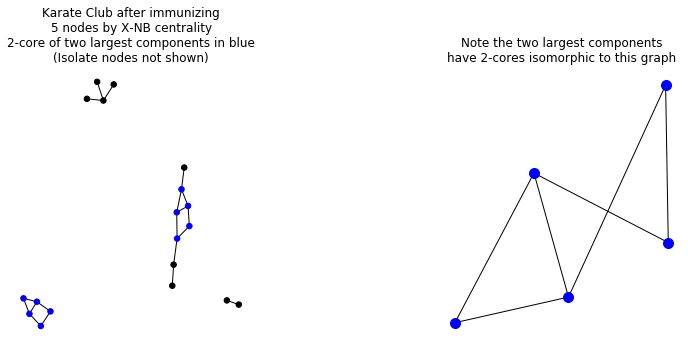

In [36]:
graph = nx.karate_club_graph()
_, immunized = inbox.immunize(graph, 5, strategy='xnb')
no_isolates = immunized.subgraph(n for n in immunized if immunized.degree(n) > 0)

_, axes = plt.subplots(1, 2, figsize=(12, 5))
nx.draw(no_isolates, node_size=30, ax=axes[0], with_labels=False,
        node_color=['k', 'b', 'b', 'b', 'k', 'k', 'b', 'k', 'k', 'b', 'b', 'b', 'b', 'k', 'b', 'k', 'k', 'k', 'b'])
axes[0].set_title('Karate Club after immunizing\n5 nodes by X-NB centrality\n2-core of two largest components in blue\n(Isolate nodes not shown)');
nx.draw(nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (4, 0), (4, 1)]), node_size=100, ax=axes[1], node_color='b')
axes[1].set_title('Note the two largest components\nhave 2-cores isomorphic to this graph');
plt.subplots_adjust(wspace=0.8)

The above plot shows that the 2-cores of the two largest components of the Karate Club graph after immunizing 5 nodes using strategy `xnb` are isomorphic. In this case, both components determine the largest eigenvalues of the NB-matrix, and the principal eigenvector is no longer well-defined. Accordingly, computing the NB-centrality or X-NB-centrality of the graph is no longer supported (the behavior is undefined). In fact, computing the NB-centrality of a node in this pathological case may return different values.

In [37]:
print(inbox.nb_centrality(immunized)[4],
      inbox.nb_centrality(immunized)[4])

-0.5334363446339787 0.6467638885214784


And ditto for X-NB centrality.

In [38]:
print(inbox.x_nb_centrality(immunized)[4],
      inbox.x_nb_centrality(immunized)[4])

0.7210095375238408 0.20176071663935585


Note that in this case, only the `nb` and `xnb` strategies are affected. The Degree, Core, Collective Influence, and X-degree values are well defined in all cases and there is no problem in continuing to immunize the graph with the corresponding strategies.

In [39]:
print(inbox.x_degree(immunized)[4],
      inbox.x_degree(immunized)[4])

4 4


-----

## References

<span id="ref-1"> [1] Martin, Travis, Xiao Zhang, and Mark EJ Newman. **"Localization and centrality in networks."** Physical review E 90.5 (2014): 052808.</span>

<span id="ref-2"> [2] Radicchi, Filippo, and Claudio Castellano. **"Leveraging percolation theory to single out influential spreaders in networks."** Physical Review E 93.6 (2016): 062314.</span>
    
<span id="ref-3"> [3] Morone, Flaviano, and Hernán A. Makse. **"Influence maximization in complex networks through optimal percolation."** Nature 524.7563 (2015): 65-68.</span>

<span id="ref-4"> [4] Chen, Chen, et al. **"Node immunization on large graphs: Theory and algorithms."** IEEE Transactions on Knowledge and Data Engineering 28.1 (2015): 113-126.</span>